# QUBO Problem

## 🧩 Problem Overview

We are given:
- **5 events** scheduled across the **weekend** (Saturday and Sunday).
- **5 persons** are available.
- Each person must attend **exactly two events** out of the 5.
- Our **objective** is to **maximize the total edge weight**, where:
  - **Nodes** represent the events.
  - **Edges** represent a pair of events that a person attends.
  - Each person contributes one edge connecting their two chosen events.

## 🖼️ Graph Representation

- **Nodes**: 5 Events — E1, E2, E3, E4, E5
- **Edges**: Each pair of events attended by a person.

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from collections import Counter

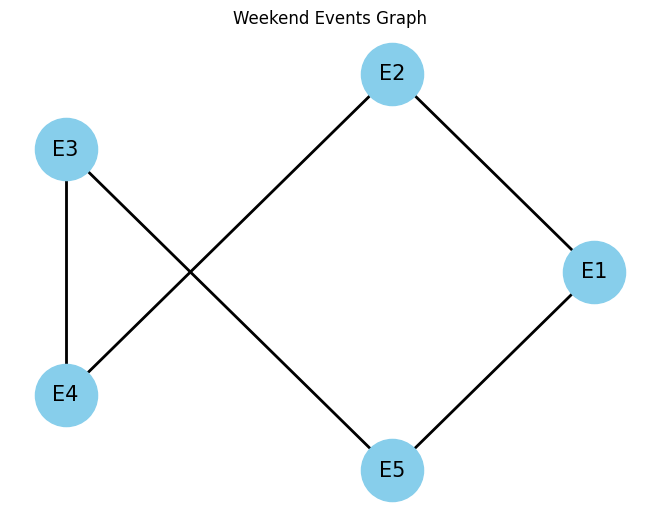

In [18]:
# --- Step 1: Define the problem graph (visualization) ---
G = nx.Graph()
events = ["E1", "E2", "E3", "E4", "E5"]
G.add_nodes_from(events)
edges = [("E1", "E2"), ("E2", "E4"), ("E3", "E4"), ("E3", "E5"), ("E1", "E5")]
G.add_edges_from(edges)

pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=15)
nx.draw_networkx_edges(G, pos, width=2)
plt.title("Weekend Events Graph")
plt.show()

### Events and People

- **Events**: $E_1$, $E_2$, $E_3$, $E_4$, $E_5$  
- **People**: $P_1$, $P_2$, $P_3$, $P_4$

---

### Preferences

- $P_1$ wants to go to $E_1$ and $E_4$  
- $P_2$ wants to go to $E_2$ and $E_3$  
- $P_3$ wants to go to $E_4$ and $E_5$  
- $P_4$ wants to go to $E_3$ and $E_4$

### Binary Variables

- $x_i = 0$ if the *i*-th event is on **Saturday**  
- $x_i = 1$ if the *i*-th event is on **Sunday**

---

### Original Formulation

$$
f(x_1, x_2, x_3, x_4, x_5) = 4 + x_1 + x_2 + 2x_3 + 3x_4 + x_5 - 2x_1x_4 - 2x_2x_3 - 2x_4x_5 - 2x_3x_4
$$

---

### Change of Variable

Let:

- $z_i = 1$ if the *i*-th event is on **Saturday**  
- $z_i = -1$ if the *i*-th event is on **Sunday**

Then:

$$
x_i = \frac{1 - z_i}{2}
$$

---

### New Formulation

$$
f(z_1, z_2, z_3, z_4, z_5) = 6 - \frac{1}{2} z_1 z_4 - \frac{1}{2} z_2 z_3 - \frac{1}{2} z_4 z_5 - \frac{1}{2} z_3 z_4
$$


In [19]:
# --- Step 2: QUBO Hamiltonian for the problem ---
H = - (6*qml.Identity(1)
       - 0.5*qml.PauliZ(1) @ qml.PauliZ(4)
       - 0.5*qml.PauliZ(2) @ qml.PauliZ(3)
       - 0.5*qml.PauliZ(4) @ qml.PauliZ(5)
       - 0.5*qml.PauliZ(3) @ qml.PauliZ(4))

print("Hamiltonian of the QUBO problem is:\n", H)

Hamiltonian of the QUBO problem is:
 -1 * (6 * I(1) + -1 * ((0.5 * Z(1)) @ Z(4)) + -1 * ((0.5 * Z(2)) @ Z(3)) + -1 * ((0.5 * Z(4)) @ Z(5)) + -1 * ((0.5 * Z(3)) @ Z(4)))


In [20]:
# --- Step 3: Define optimizer circuit ---
dev = qml.device("default.qubit", wires=H.wires)

@qml.qnode(dev)
def circuit(params):
    for param, wire in zip(params, H.wires):
        qml.RY(param, wires=wire)
    return qml.expval(H)

params = np.random.rand(len(H.wires))
opt = qml.AdagradOptimizer(stepsize=0.5)
epochs = 200

for i in range(epochs):
    params = opt.step(circuit, params)

In [21]:
# --- Step 4: Sampling from optimized circuit ---
# Use measurement sampling (shots = 1000)
dev_sample = qml.device("default.qubit", wires=H.wires, shots=1000)

@qml.qnode(dev_sample)
def sampling_circuit(params):
    for param, wire in zip(params, H.wires):
        qml.RY(param, wires=wire)
    return qml.sample()

In [22]:
# --- Step 5: Run circuit and get most frequent outcome ---
samples = sampling_circuit(params)
samples_str = ["".join(str(bit) for bit in s) for s in samples]

# Count frequencies
counts = Counter(samples_str)

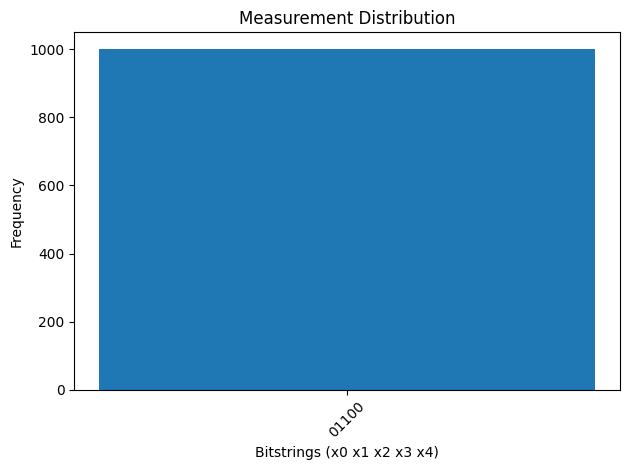

In [23]:
# Plot distribution
plt.bar(counts.keys(), counts.values())
plt.xlabel("Bitstrings (x0 x1 x2 x3 x4)")
plt.ylabel("Frequency")
plt.title("Measurement Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# --- Step 6: Get most probable assignment ---
most_common = counts.most_common(1)[0][0]  # Most probable string

print(f"\nMost probable assignment: {most_common}")


Most probable assignment: 01100


In [25]:
# --- Step 7: Decode into Saturday/Sunday ---
print("\nAssignment per person:")
for i, bit in enumerate(most_common):
    day = "Sunday" if bit == "1" else "Saturday"
    print(f"Person {i}: {day}")


Assignment per person:
Person 0: Saturday
Person 1: Sunday
Person 2: Sunday
Person 3: Saturday
Person 4: Saturday
